In [10]:
!python --version

Python 3.10.12


In [14]:
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/output.1
ta-lib/autom4te.cache/traces.0
ta-lib/autom4te.cache/traces.1
ta-lib/ltmain.sh
ta-lib/ta-lib-config.in
ta-lib/src/
ta-lib/src/ta_func/
ta-lib/src/ta_func/ta_MACDFIX.c
ta-lib/src/ta_func/ta_CDLPIERCING.c
ta-lib/src/ta_func/ta_DIV.c
ta-lib/src/ta_func/ta_ROCR100.c
ta-lib/src/ta_func/ta_ADXR.c
ta-lib/src/ta_func/ta_MAVP.c
ta-lib/src/ta_func/ta_CDLCLOSINGMARUBOZU.c
ta-lib/src/ta_func/ta_COSH.

In [7]:
!pip install numba
!pip install matplotlib
!pip install mplfinance
!pip install python-dateutil
!pip install scikit-learn
!pip install tindicators
!pip install git+https://github.com/philipzabicki/finta.git@philipzabicki-patch-1
!pip install ta
!pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.6/369.6 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for ta-lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ta-lib
Failed to build ta-lib
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ta-lib)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.5 MB/s eta 0:00:00
  Cloning https://github.com/philipzabicki/finta.git (to revision philipzabicki-patch-1) to /tmp/pip-req-build-x81j9bfd
  Running command git clone --filter=blob:none --quiet https://github.com/philipzabicki/finta.git 

In [1]:
import pandas as pd
import numpy as np
from utils.ta_tools import get_MA_band_signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [2]:
def keltner_channels_custom_mas(df, ma_periods, atr_periods, atr_multipliers):
    """
    eg. arguments
    ma_periods = [5, 10, 25, 50, 75, 100]
    atr_perods = [5, 10, 15, 20, 25, 30, 40, 50]
    atr_multipliers = [.25, .5, 1., 1.25, 1.5, 1.75, 2., 2.5, 3.]
    res is 16_416 columns
    """
    # taking only ohlc values and converting to nump for speed
    np_df = df.iloc[:, 1:6].to_numpy()
    print(np_df)
    for ma_p in ma_periods:
        print(f"ma_p: {ma_p}")
        for atr_p in atr_periods:
            for atr_m in atr_multipliers:
                for ma_id in range(0, 38):
                    df[f"{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}"] = (
                        get_MA_band_signal(np_df, ma_id, ma_p, atr_p, atr_m)
                    )
    return df


def add_scaled_ultosc_rsi_mfi_up_to_n(df, n, step=1):
    indicator_columns = []
    new_columns = {}
    for p in range(2, n + 1, step):
        rsi_column = f"RSI{p}"
        new_columns[rsi_column] = talib.RSI(df["Close"], timeperiod=p)
        indicator_columns.append(rsi_column)
    for p in range(2, n + 1, step):
        mfi_column = f"MFI{p}"
        new_columns[mfi_column] = talib.MFI(
            df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=p
        )
        indicator_columns.append(mfi_column)
    for p in range(1, n + 1, step):
        ultosc_column = f"ULTOSC{p}"
        new_columns[ultosc_column] = talib.ULTOSC(
            df["High"],
            df["Low"],
            df["Close"],
            timeperiod1=p,
            timeperiod2=2 * p,
            timeperiod3=3 * p,
        )
        indicator_columns.append(ultosc_column)
    new_columns_df = pd.DataFrame(new_columns, index=df.index)
    df = pd.concat([df, new_columns_df], axis=1)
    df[indicator_columns] = df[indicator_columns].fillna(0)
    if indicator_columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df[indicator_columns] = scaler.fit_transform(df[indicator_columns])
    return df


def add_scaled_candle_patterns_indicators(df):
    candle_names = talib.get_function_groups().get("Pattern Recognition", [])
    pattern_columns = []
    new_columns = {}
    for pattern_name in candle_names:
        pattern_function = getattr(talib, pattern_name)
        new_columns[pattern_name] = pattern_function(
            df["Open"], df["High"], df["Low"], df["Close"]
        )
        pattern_columns.append(pattern_name)
    new_columns_df = pd.DataFrame(new_columns, index=df.index)
    df = pd.concat([df, new_columns_df], axis=1)
    if pattern_columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df[pattern_columns] = scaler.fit_transform(df[pattern_columns])
    return df

In [42]:
df = pd.read_csv("/content/final_combined_actions.csv")
df

,Opened,Open,High,Low,Close,Volume,Action
0,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1
1,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0
2,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0
3,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0
4,2017-08-17 09:00:00,4360.00,4445.78,4360.00,4444.00,10.763623,0
...,...,...,...,...,...,...,...
46075,2022-11-19 00:00:00,16699.43,16708.77,16662.26,16664.26,3705.208100,0
46076,2022-11-19 01:00:00,16664.77,16682.71,16650.72,16664.75,3366.466430,0
46077,2022-11-19 02:00:00,16665.69,16665.70,16573.94,16624.24,6400.823370,0
46078,2022-11-19 03:00:00,16624.24,16652.96,16611.89,16628.70,3636.335900,0


In [ ]:
df = keltner_channels_custom_mas(
    df, [2, 3, 4, 5, 6, 7, 8, 9, 10], [2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0]
)
df = add_scaled_candle_patterns_indicators(df)
df = add_scaled_ultosc_rsi_mfi_up_to_n(df_train, 50, 1)

[[4.30883000e+03 4.32869000e+03 4.29137000e+03 4.31532000e+03
  2.32349160e+01]
 [4.33029000e+03 4.34545000e+03 4.30937000e+03 4.32435000e+03
  7.22969100e+00]
 [4.31662000e+03 4.34999000e+03 4.28741000e+03 4.34999000e+03
  4.44324900e+00]
 ...
 [1.66656900e+04 1.66657000e+04 1.65739400e+04 1.66242400e+04
  6.40082337e+03]
 [1.66242400e+04 1.66529600e+04 1.66118900e+04 1.66287000e+04
  3.63633590e+03]
 [1.66287000e+04 1.66490000e+04 1.66151100e+04 1.66351400e+04
  3.37747881e+03]]
ma_p: 2


<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

ma_p: 3


<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

ma_p: 4


<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{ma_id}MAp{ma_p}atr_p{atr_p}atr_m{atr_m}'] = get_MA_band_signal(np_df, ma_id, ma_p, atr_p,
<ipython-input-41-53804591ad39>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [ ]:
df

<Axes: >

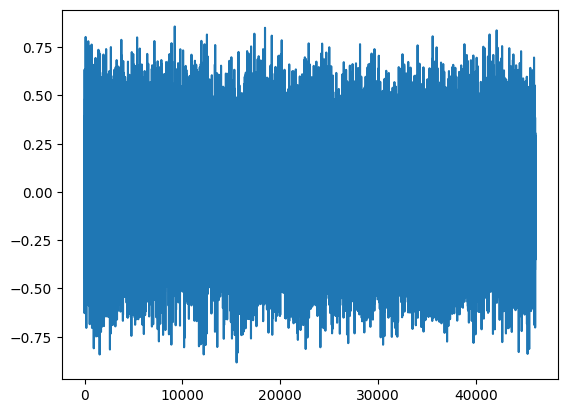

In [34]:
df["0MAp2atr_p2atr_m1.0"].plot()

Random Forest

In [35]:
X = df.drop(columns=["Opened", "Open", "High", "Low", "Close", "Volume", "Action"])
y = df["Action"]
# Podział na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Trenowanie modelu Random Forest
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

Accuracy: 0.5669126157407407
              precision    recall  f1-score   support

          -1       0.53      0.49      0.51      3234
           0       0.60      0.61      0.60      7474
           1       0.52      0.54      0.53      3116

    accuracy                           0.57     13824
   macro avg       0.55      0.55      0.55     13824
weighted avg       0.57      0.57      0.57     13824



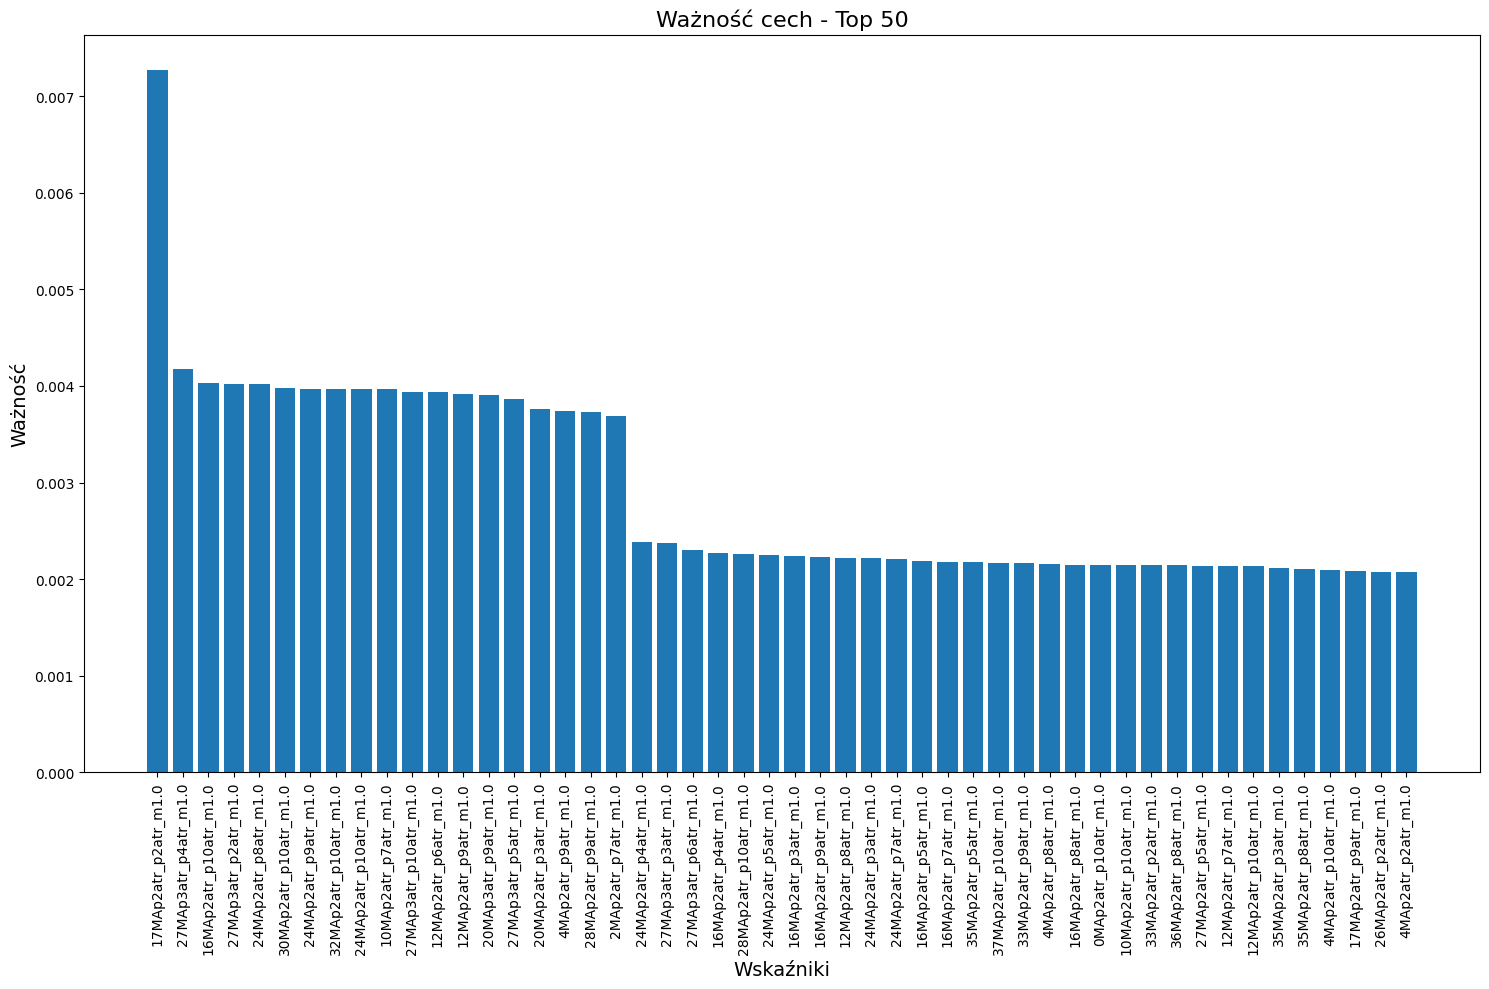

In [36]:
# Predykcje
y_pred = model.predict(X_test)

# Ocena modelu
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Ważność cech
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Liczba top cech do wyświetlenia
top_n = 50

plt.figure(figsize=(15, 10))  # Zwiększenie rozmiaru wykresu
plt.title("Ważność cech - Top 50", fontsize=16)
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(
    range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90, fontsize=10
)
plt.xlabel("Wskaźniki", fontsize=14)
plt.ylabel("Ważność", fontsize=14)
plt.tight_layout()  # Zapewnia, że etykiety nie zostaną obcięte
plt.show()